Import Lib's

In [1]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import * 
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import re
import warnings
warnings.filterwarnings("ignore")

Extraxt and Import the dataset files

In [2]:
from zipfile import ZipFile 
with ZipFile('../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip', 'r') as zip:
    zip.extractall() 
with ZipFile('../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip', 'r') as zip:
    zip.extractall() 

In [3]:
train = pd.read_csv('./train.tsv', sep="\t")
test = pd.read_csv('./test.tsv', sep="\t")


Analyse the data

In [4]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [5]:
train.Sentiment.value_counts()


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [6]:
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [7]:
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [8]:
train.Sentiment.unique()

array([1, 2, 3, 4, 0])

In [9]:
train.SentenceId.unique()

array([   1,    2,    3, ..., 8542, 8543, 8544])

Handing the Imbalanced data

In [10]:
train_0 = train[train['Sentiment'] == 0].sample(frac=1)
train_1 = train[train['Sentiment'] == 1].sample(frac=1)
train_2 = train[train['Sentiment'] == 2].sample(frac=1)
train_3 = train[train['Sentiment'] == 3].sample(frac=1)
train_4 = train[train['Sentiment'] == 4].sample(frac=1)

# we want a balanced set for training against - there are 7072 `0` examples
sample_size = min(len(train_0), len(train_1), len(train_2), len(train_3), len(train_4))

train = pd.concat([train_0.head(sample_size), train_1.head(sample_size), train_2.head(sample_size), train_3.head(sample_size), train_4.head(sample_size)]).sample(frac=1)

In [11]:
train

,PhraseId,SentenceId,Phrase,Sentiment
97798,97799,5120,an amateurish screenplay,0
141528,141529,7678,", the picture begins to resemble the shapeless...",0
81229,81230,4187,Moore provides an invaluable service by sparki...,4
121122,121123,6486,the absolute last thing we need Hollywood doin...,1
89696,89697,4667,is less a documentary and more propaganda,2
...,...,...,...,...
56067,56068,2805,comedy Death,0
102563,102564,5398,a good film in `` Trouble Every Day,4
113031,113032,6002,is so clumsily sentimental and ineptly directe...,0
101098,101099,5313,that it has a screenplay written by Antwone Fi...,2


Sentence cleaner

In [12]:
# Sentence Cleaning

from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from string import punctuation
import re
from tqdm import tqdm

stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()

def cleaner(phrase):
    cleaned=[]
    for i in tqdm(range(0,len(phrase))):
        review=str(phrase[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        cleaned.append(review)
    return cleaned


In [13]:
train['cleaned_phrase']=cleaner(train.Phrase.values)
test['cleaned_phrase']=cleaner(test.Phrase.values)


100%|██████████| 66292/66292 [00:15<00:00, 4360.03it/s]


In [14]:
train = train.drop(labels='Phrase',axis=1)
test = test.cleaned_phrase.values

In [15]:
train

,PhraseId,SentenceId,Sentiment,cleaned_phrase
97798,97799,5120,0,an amateurish screenplay
141528,141529,7678,0,the picture begin to resemble the shapeless gr...
81229,81230,4187,4,moore provides an invaluable service by sparki...
121122,121123,6486,1,the absolute last thing we need hollywood doin...
89696,89697,4667,2,is le a documentary and more propaganda
...,...,...,...,...
56067,56068,2805,0,comedy death
102563,102564,5398,4,a good film in trouble every day
113031,113032,6002,0,is so clumsily sentimental and ineptly directe...
101098,101099,5313,2,that it ha a screenplay written by antwone fis...


In [16]:
from keras.utils import to_categorical
X = train.cleaned_phrase.values
y = train.Sentiment.values
y = to_categorical(y)

Splitting the data into train test

In [17]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.20,stratify=y,random_state=50)

In [18]:
# Maximum Features
max_features=len(FreqDist(word_tokenize(' '.join(X_train))))
max_features

12227

In [19]:
# The maximum sentence length
len_of_words=[]
for text in tqdm(X_train):
    max_phrase_len=np.max(len_of_words.append(len(word_tokenize(text))))


100%|██████████| 28288/28288 [00:06<00:00, 4462.25it/s]


In [20]:
# converting text to seq and seq padding 

tokenizer = Tokenizer(num_words=max_features, oov_token='<unw>')
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen=max_phrase_len)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(X_val, maxlen=max_phrase_len)


In [21]:
X_train.shape

(28288, 48)

In [22]:
y_train.shape

(28288, 5)

Modelling with LSTM

In [23]:
model = Sequential()

model.add(Embedding(max_features, 100, input_length=48,mask_zero=True))

model.add(LSTM(128,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))

model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1222700   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,389,681
Trainable params: 1,389,681
Non-trainable params: 0
_________________________________________________________________


Training Time

In [24]:
# Fitiing the data
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=7, batch_size=64, verbose=1)

Epoch 1/7
442/442 [==============================] - 86s 195ms/step - loss: 1.3692 - accuracy: 0.4148 - val_loss: 1.1313 - val_accuracy: 0.5308
Epoch 2/7
442/442 [==============================] - 85s 193ms/step - loss: 1.0433 - accuracy: 0.5665 - val_loss: 1.0383 - val_accuracy: 0.5629
Epoch 3/7
442/442 [==============================] - 86s 195ms/step - loss: 0.9116 - accuracy: 0.6232 - val_loss: 1.0324 - val_accuracy: 0.5700
Epoch 4/7
442/442 [==============================] - 85s 193ms/step - loss: 0.8304 - accuracy: 0.6626 - val_loss: 1.0466 - val_accuracy: 0.5737
Epoch 5/7
442/442 [==============================] - 85s 193ms/step - loss: 0.7693 - accuracy: 0.6922 - val_loss: 1.0620 - val_accuracy: 0.5727
Epoch 6/7
442/442 [==============================] - 85s 193ms/step - loss: 0.7193 - accuracy: 0.7154 - val_loss: 1.1118 - val_accuracy: 0.5732
Epoch 7/7
442/442 [==============================] - 86s 194ms/step - loss: 0.6769 - accuracy: 0.7339 - val_loss: 1.1600 - val_accuracy:

Performance Plotting

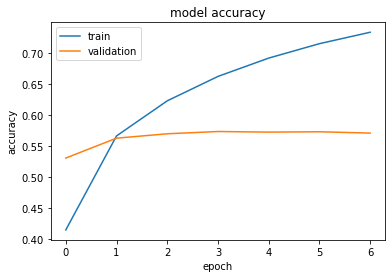

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

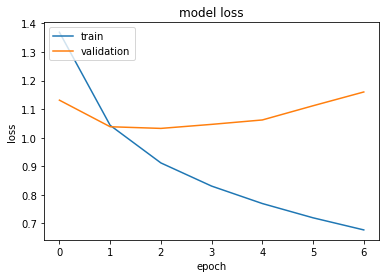

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Predictions on the test data

In [27]:
t = pd.read_csv('./test.tsv', sep="\t")
t

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [28]:
test = cleaner(t.Phrase.values)
test = tokenizer.texts_to_sequences(test)
test = sequence.pad_sequences(test, 48)

100%|██████████| 66292/66292 [00:15<00:00, 4394.46it/s]


In [29]:
y_pred=model.predict_classes(test, verbose=1)

2072/2072 [==============================] - 71s 34ms/step


In [30]:
test = pd.read_csv('./test.tsv', sep="\t")

In [31]:
test['Sentiment'] = y_pred

In [32]:
test

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,3
1,156062,8545,An intermittently pleasing but mostly routine ...,3
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,3
4,156065,8545,intermittently pleasing but mostly routine,3
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",0
66288,222349,11855,"A long-winded , predictable scenario",0
66289,222350,11855,"A long-winded ,",1
66290,222351,11855,A long-winded,1
